In [1]:
%matplotlib inline

In [132]:
#%%writefile utils.py
import pandas as pd
import numpy as np
from ggplot import *

def compute_prob_vector(ps_file, prob_paired=True):
    '''
    Given a text file derived from the RNAfold output of the form
    
    i    j    sqrt(prob)   ubox
    
    computes a vector (dict) of probabilities for every nucleotide
    to be in paired (or unpaired) state.
    '''
    prob_vector = {}
    with open(ps_file) as fi:
        for line in fi.readlines():
            line = line.strip()
            posi, posj, sqrt_prob, box = line.split()
            curr_i = prob_vector.get(int(posi), 0)
            curr_j = prob_vector.get(int(posj), 0)
            prob_vector.update({
                int(posi)-1: curr_i + float(sqrt_prob)**2,
                int(posj)-1: curr_j + float(sqrt_prob)**2,
            })
    if prob_paired:
        return prob_vector
    else:
        return dict([(pos, 1-p) for pos,p in prob_vector.items()])
    
def compute_prob_vector_max(ps_file, prob_paired=True):
    '''
    Given a text file derived from the RNAfold output of the form
    
    i    j    sqrt(prob)   ubox
    
    computes a vector (dict) of probabilities for every nucleotide
    to be in paired (or unpaired) state.
    '''
    prob_vector = {}
    with open(ps_file) as fi:
        for line in fi.readlines():
            line = line.strip()
            posi, posj, sqrt_prob, box = line.split()
            curr_i = prob_vector.get(int(posi), 0)
            curr_j = prob_vector.get(int(posj), 0)
            curr_prob = float(sqrt_prob)**2
            indi = int(posi)
            indj = int(posj)
            if indi in prob_vector:
                if curr_prob > prob_vector[indi]:
                    prob_vector[indi] = curr_prob
            else:
                prob_vector[indi] = curr_prob
            if indj in prob_vector:
                if curr_prob > prob_vector[indj]:
                    prob_vector[indj] = curr_prob
            else:
                prob_vector[indj] = curr_prob
                
    if prob_paired:
        return prob_vector
    else:
        return dict([(pos, 1-p) for pos,p in prob_vector.items()])
    

def trange_df(base_name, prob_func=compute_prob_vector, 
              trange=range(35,43), abs_value=True):
    '''
    Same as `compute_diff_df` but builds dataframe in a long format
    suitable for ggplot faceting.
    '''
    T0 = trange[0]
    prob0 = prob_func('%s_%d.txt' % (base_name, T0))
    chunks = []
    for temp in trange[1:]:
        df = pd.DataFrame()
        prob_vector = prob_func('%s_%d.txt' % (base_name,temp))
        npos = max(set(prob0.keys()) | set(prob_vector.keys())) + 1
        d0 = np.zeros(npos)
        dt = np.zeros(npos)
        d0[list(prob0.keys())] = list(prob0.values())
        dt[list(prob_vector.keys())] = list(prob_vector.values())
        df['pos'] = range(npos)
        if abs_value:
            df['Diff'] = abs(d0 - dt)
        else:
            df['Diff'] = dt - d0
        df['Temp'] = temp
        chunks.append(df)
    return pd.concat(chunks)

def sig_positions(df, num_sigma=6):
    mean = df['Diff'].mean()
    sigma = df['Diff'].std()
    threshold = num_sigma * sigma
    return abs(df['Diff'] - mean) > threshold


def compute_diff_df(base_name, trange=range(35,43), abs_value=True):
    '''
    Given the base_name for tab-delimited files containing base
    pairing probabilities calculated by RNAfold computes a
    dataframe containing probability difference vectors for each
    temperature value in the range relative to the lowest T in the
    range.
    '''
    T0 = trange[0]
    prob = compute_prob_vector('%s_%d.txt' % (base_name, T0))
    df = pd.DataFrame(prob.items(), columns=['Position', 'Prob_%d' % T0])
    for temp in trange[1:]:
        prob = compute_prob_vector('%s_%d.txt' % (base_name, temp))
        prob_key = 'Prob_%d' % temp
        df[prob_key] = pd.Series(prob.values())
        if abs_value:
            df['Diff_%d' % temp] = abs(df[prob_key] - df['Prob_%d' % T0])
        else:
            df['Diff_%d' % temp] = df[prob_key] - df['Prob_%d' % T0]
    return df

def get_sig_positions(df, trange=range(37,43), num_sigma=6):
    '''
    Given the dataframe of probability differences for a T range
    and the level of significannce in sigmas returns positions in the
    dataframe where the probability difference at the highest T
    exceeds the sigma threshold.
    '''
    colnames = ['Diff_%d' % temp for temp in trange[1:]]
    diff_cols = [df[colname] for colname in colnames]
    all_diff = pd.concat(diff_cols)
    mean = all_diff.mean()
    sigma = all_diff.std()
    threshold = num_sigma * sigma
    print('Mean:\t%f\nSigma:\t%f\nThreshold:\t%f\n' % (mean, sigma, threshold))
    return df[abs(df['Diff_%d' % trange[-1]] - mean) > threshold].sort(['Position'])

def plot_RSMD(df, trange=range(37,43)):
   df_sum = pd.DataFrame()
   df_sum['Temp'] = trange[1:]
   df_sum['RMSD'] = [np.sqrt(((df[df['Temp'] == T]['Diff'])**2).sum()) for T in trange[1:]]
   p = ggplot(df_sum, aes(x='Temp', y='RMSD')) + geom_line()
   return p


Writing utils.py


In [131]:
ls -lah

total 4.7M
drwxrwxr-x 4 ilya ilya 4.0K Jul 16 16:56 ./
drwxrwxr-x 5 ilya ilya 4.0K Jul 16 11:19 ../
-rw-rw-r-- 1 ilya ilya  19K Jul 16 11:19 BASH basics.ipynb
-rw-rw-r-- 1 ilya ilya 5.0K Jul 16 11:19 Environments.ipynb
-rw-rw-r-- 1 ilya ilya 9.0K Jul 16 11:19 Formats.ipynb
-rw-rw-r-- 1 ilya ilya  55K Jul 16 11:19 grad.ipynb
-rw-rw-r-- 1 ilya ilya 1.9K Jul 16 11:19 Intro.ipynb
drwxrwxr-x 2 ilya ilya 4.0K Jul 16 15:19 .ipynb_checkpoints/
-rw-rw-r-- 1 ilya ilya  47K Jul 16 11:19 kallisto.ipynb
drwxrwxr-x 2 ilya ilya 4.0K Jul 16 14:17 nbdime_test/
-rw-rw-r-- 1 ilya ilya 7.1K Jul 16 11:19 ocean.ipynb
-rw-rw-r-- 1 ilya ilya  59K Jul 16 11:19 Python.ipynb
-rw-rw-r-- 1 ilya ilya 2.1M Jul 16 11:19 rnafold.ipynb
-rw-rw-r-- 1 ilya ilya 279K Jul 16 16:56 ROSE-analysis.ipynb
-rw-rw-r-- 1 ilya ilya  20K Jul 16 12:49 ROSE.ipynb
-rw-rw-r-- 1 ilya ilya  56K Jul 16 11:19 sleuth.ipynb
-rw-rw-r-- 1 ilya ilya 7.5K Jul 16 11:19 Stats.ipynb
-rw-rw-r-- 1 ilya ilya 1.8K Jul 16 11:19 Tools.ipynb
-rw-rw-r-- 1 il

In [112]:
df = trange_df('../data/ROSE1', trange=range(25,37))
df

,pos,Diff,Temp
0,0,0.000010,26
1,1,0.000008,26
2,2,0.000005,26
3,3,0.000023,26
4,4,0.000002,26
5,5,0.000028,26
6,6,0.000000,26
7,7,0.000000,26
8,8,0.000000,26
9,9,0.000000,26


In [113]:
compute_prob_vector('../data/ROSE1_25.txt')

{0: 7.293650204236902e-05,
 1: 5.0568624990244e-05,
 2: 0.9999576804477457,
 3: 0.9995141630237306,
 4: 0.9999912980189313,
 5: 0.9996765861533583,
 10: 5.983055353786881,
 11: 4.983378767633523,
 12: 3.9833874696145917,
 13: 2.983873306590861,
 14: 0.984090824872533,
 15: 0.0020798875342546565,
 16: 7.237818580636902e-05,
 17: 6.7494029475625e-05,
 18: 0.047785248678247134,
 19: 0.9960192435103237,
 20: 1.6493970870729002e-05,
 21: 0.9989927683104574,
 22: 0.99993502608774,
 23: 0.9997558053908696,
 24: 6.291659227200399e-05,
 25: 7.276281073254398e-05,
 26: 8.283158660659601e-05,
 27: 8.380162958832901e-05,
 28: 8.391926727651602e-05,
 29: 8.389999417363598e-05,
 30: 3.9153302707599996e-05,
 32: 3.995928260085956,
 33: 3.9957898004220054,
 34: 3.9957485469890996,
 35: 3.995705051646407,
 36: 2.995813078904309,
 37: 1.9968852523860037,
 38: 1.9967990393597042,
 39: 0.002821775132529754,
 40: 0.002805281161659025,
 41: 0.7431697907446666,
 42: 0.09825090353030147,
 43: 0.09816677241079

In [114]:
compute_prob_vector_max('../data/ROSE1_25.txt')

{1: 0.9840499156343959,
 2: 0.9998657105087196,
 3: 0.9999576804477457,
 4: 0.9995141630237306,
 5: 0.9999912980189313,
 6: 0.9996765861533583,
 11: 0.9996765861533583,
 12: 0.9999912980189313,
 13: 0.9995141630237306,
 14: 0.9999576804477457,
 15: 0.9998657105087196,
 16: 0.9840499156343959,
 17: 0.5398343211381459,
 18: 0.5403344632144405,
 19: 0.5398945210575226,
 20: 0.9960192435103237,
 21: 0.9979745146877215,
 22: 0.9989277116048189,
 23: 0.9998919969163239,
 24: 0.9997348195824949,
 25: 0.9988510602053833,
 26: 7.276281073254398e-05,
 27: 0.9979466191768194,
 28: 0.9982364182415525,
 29: 8.5073210508196e-05,
 30: 8.389999417363598e-05,
 31: 3.9153302707599996e-05,
 33: 0.9982364182415525,
 34: 0.9979466191768194,
 35: 0.9988510602053833,
 36: 0.9997348195824949,
 37: 0.9998919969163239,
 38: 0.9989277116048189,
 39: 0.9979745146877215,
 40: 0.9960192435103237,
 41: 0.002805281161659025,
 42: 0.3597551588441567,
 43: 0.3700935246972657,
 44: 0.5398945210575226,
 45: 0.54033446321

In [115]:
df = trange_df('../data/ROSE1', trange=range(25,37))
df

,pos,Diff,Temp
0,0,0.000010,26
1,1,0.000008,26
2,2,0.000005,26
3,3,0.000023,26
4,4,0.000002,26
5,5,0.000028,26
6,6,0.000000,26
7,7,0.000000,26
8,8,0.000000,26
9,9,0.000000,26


In [116]:
df_max = trange_df('../data/ROSE1', prob_func=compute_prob_vector_max, 
                   trange=range(25,37))
df_max

,pos,Diff,Temp
0,0,0.000000,26
1,1,0.000510,26
2,2,0.000019,26
3,3,0.000005,26
4,4,0.000023,26
5,5,0.000002,26
6,6,0.000028,26
7,7,0.000000,26
8,8,0.000000,26
9,9,0.000000,26


In [117]:
df.describe()

,pos,Diff,Temp
count,1287.000000,1287.000000,1287.000000
mean,58.000000,0.176883,31.000000
std,33.786886,0.609991,3.163507
min,0.000000,0.000000,26.000000
25%,29.000000,0.000072,28.000000
50%,58.000000,0.001462,31.000000
75%,87.000000,0.016712,34.000000
max,116.000000,5.976818,36.000000


In [118]:
df['Diff'].mean()

0.17688279916248378

In [119]:
df['Diff'].std()

0.60999103690574574

In [120]:
df[df['Temp'] == 35]

,pos,Diff,Temp
0,0,0.000211,35
1,1,0.000159,35
2,2,0.999939,35
3,3,0.999485,35
4,4,0.999962,35
5,5,0.999647,35
6,6,0.000028,35
7,7,0.000026,35
8,8,0.000022,35
9,9,5.975916,35


In [122]:
g = df.groupby('Temp')
for name,group in g:
    print(name, group)

26      pos      Diff  Temp
0      0  0.000010    26
1      1  0.000008    26
2      2  0.000005    26
3      3  0.000023    26
4      4  0.000002    26
5      5  0.000028    26
6      6  0.000000    26
7      7  0.000000    26
8      8  0.000000    26
9      9  0.000000    26
10    10  0.000586    26
11    11  0.000558    26
12    12  0.000556    26
13    13  0.000534    26
14    14  0.000505    26
15    15  0.000046    26
16    16  0.000014    26
17    17  0.000013    26
18    18  0.000270    26
19    19  0.000288    26
20    20  0.000002    26
21    21  0.000074    26
22    22  0.000008    26
23    23  0.000025    26
24    24  0.000005    26
25    25  0.000005    26
26    26  0.000014    26
27    27  0.000006    26
28    28  0.000006    26
29    29  0.000006    26
..   ...       ...   ...
87    87  0.000184    26
88    88  0.010753    26
89    89  0.015384    26
90    90  0.000016    26
91    91  0.000009    26
92    92  0.000003    26
93    93  0.001187    26
94    94  0.001190    

In [123]:
%matplotlib inline

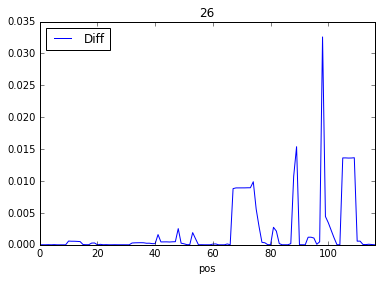

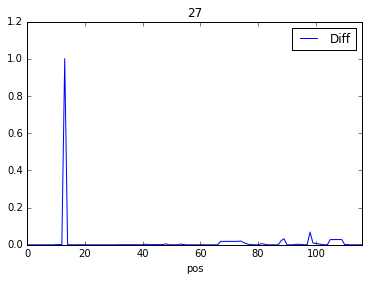

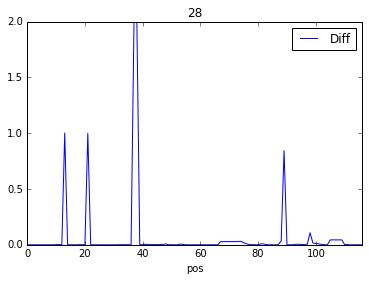

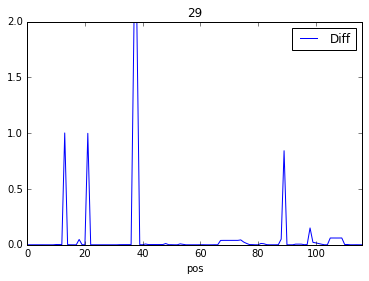

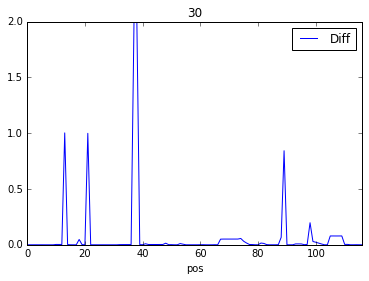

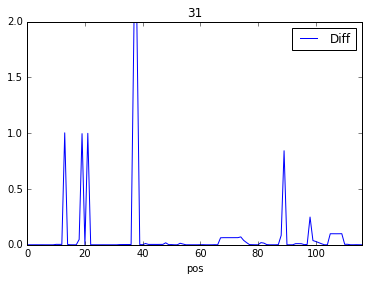

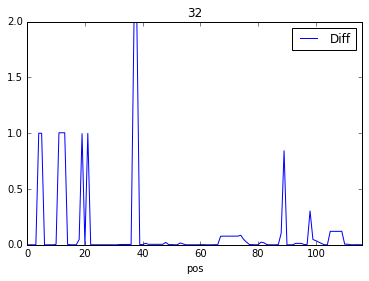

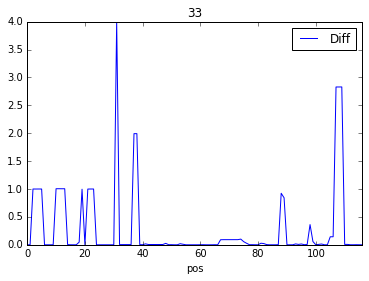

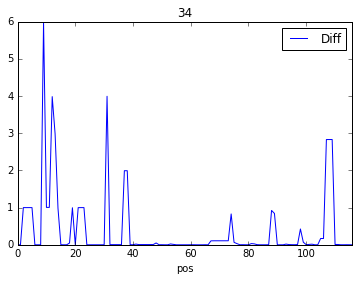

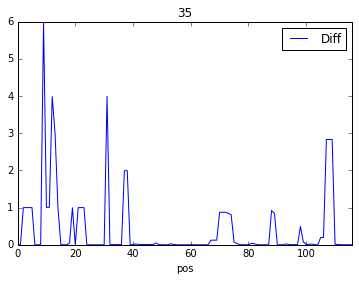

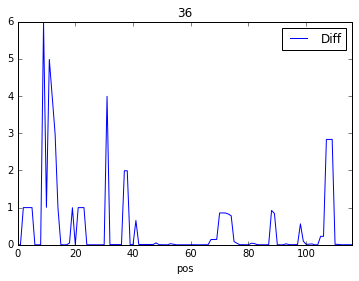

In [124]:
for name,group in g:
    group.plot(x='pos', y='Diff', title=name)

In [125]:
g = ggplot(df, aes(xmin='pos-1',xmax='pos', ymin=0, ymax='Diff')) \
    + geom_rect() \
    + facet_wrap('Temp')

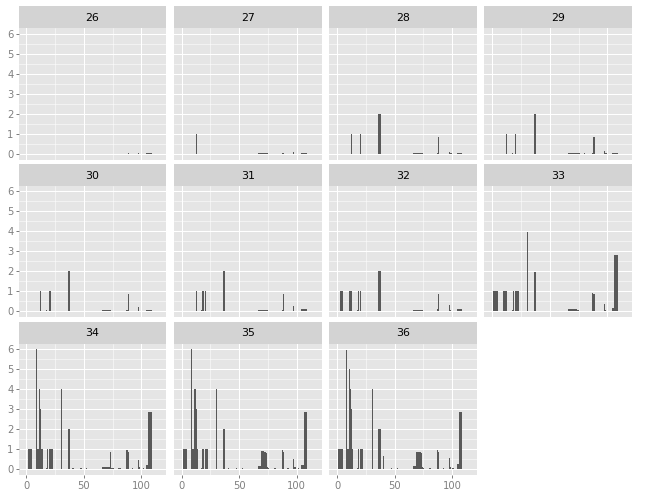

<ggplot: (8742313465071)>


In [127]:
print(g)

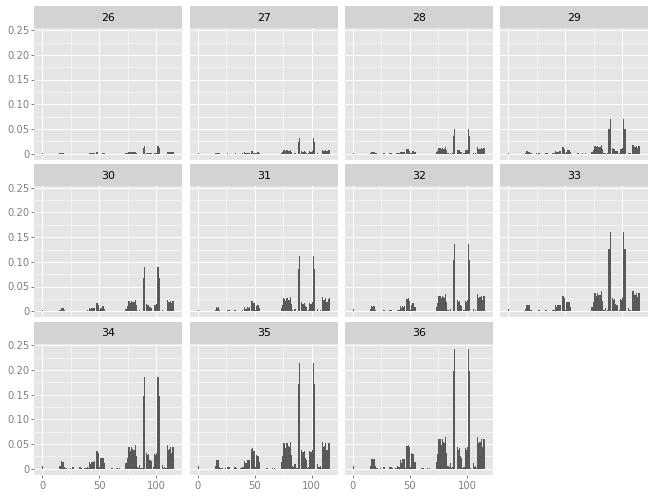

<ggplot: (8742317229611)>


In [128]:
g = ggplot(df_max, aes(xmin='pos-1',xmax='pos', ymin=0, ymax='Diff')) \
    + geom_rect() \
    + facet_wrap('Temp')
print(g)